In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, recall_score
import pickle

In [62]:
df = pd.read_csv('../Data/02_sub_reddit_data_clean.csv')

In [63]:
df.head(2)

,id,subreddit,title,utc_datetime_str,num_comments,day_name,title_word_count,negative_score,neutral_score,positive_score,compound_score
0,12xzq7k,AskMen,"Men who had an affair, left their wife, and no...",2023-04-24 22:57:05,1,Monday,12,0.203,0.797,0.0,-0.4215
1,12xzptl,AskMen,"Men, what would your thoughts be after learnin...",2023-04-24 22:56:41,0,Monday,12,0.000,1.000,0.0,0.0000


In [64]:
X=df['title']
y=df['subreddit']

In [65]:
baseline = y.value_counts(normalize=True)
baseline

AskWomen    0.505497
AskMen      0.494503
Name: subreddit, dtype: float64

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=.25, stratify=y)

# Random forest with CountVectorizer

In [67]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer())
    ,('rt', RandomForestClassifier())
])

In [68]:
cross_val_score(pipe_rf, X_train, y_train, cv=3).mean()

0.6934156378600823

In [69]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('rt', RandomForestClassifier())])

In [70]:
print(f' Training score is {pipe_rf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf.score(X_test, y_test)}')

 Training score is 0.9945987654320988
 Test score is 0.694680030840401


In [71]:
pipe_rf_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [72]:
gs_rf = GridSearchCV(pipe_rf,
                 param_grid=pipe_rf_params,
                 cv=5, n_jobs = -1)

In [ ]:
gs_rf.fit(X_train, y_train)

In [74]:
display(gs_rf.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.9,
 'cvec__max_features': 30,
 'cvec__min_df': 9,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'rt__bootstrap': True,
 'rt__max_depth': 15,
 'rt__min_samples_leaf': 5}

Best parmas for a countvector and random forest

|Param|setting|
|-----|-----|
|cvec_lowercase|True|
|cvec__max_df| .9|
|cvec__max_features| 30|
|cvec__min_df| 9|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|rt__bootstrap| True|
|rt__max_depth| 15|
|rt__min_samples_leaf| 5|

In [115]:
print(f' Training score is {gs_rf.score(X_train, y_train)}')
print(f' Test score is {gs_rf.score(X_test, y_test)}')

 Training score is 0.7361111111111112
 Test score is 0.6630686198920586


In [75]:
gs_rf.score(X_train, y_train)

0.7361111111111112

In [76]:
gs_rf.score(X_test, y_test)

0.6630686198920586

In [77]:
preds_rf = gs_rf.predict(X_test)

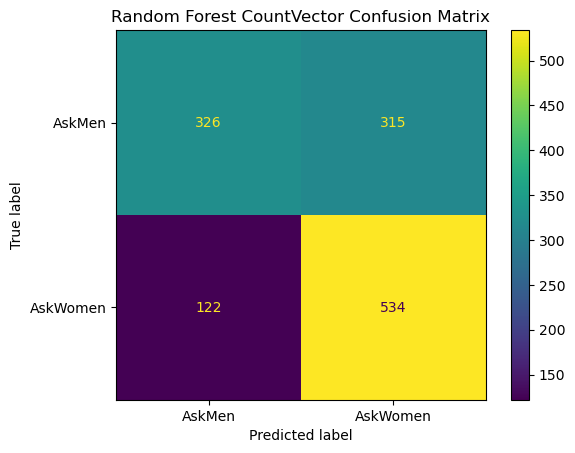

In [139]:
rf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf, X_test, y_test)
rf_matrix.ax_.set_title("Random Forest CountVector Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/rf_cvec_confusion_matrix')

In [79]:
recall_score(y_test, preds_rf, average='macro')

0.6613023667288155

In [80]:
rf_model_1 = gs

In [81]:
with open('../.Models/model_pickel1.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(rf_model_1, pickle_out)

This model does better than baseline, but is slightly overfit. It also misclassifies 36% of the predictions for Askwomen and 27% of the predictions for Askmen. With a recall score of 66% this model is not sufficient for production.

# Logistic regresion with countvectorizor

In [82]:
pipe_logr = Pipeline([
    ('cvec', CountVectorizer())
    ,('logr', LogisticRegression())
])

In [ ]:
pipe_logr.fit(X_train, y_train)

In [84]:
pipe_logr.score(X_train, y_train)

0.9012345679012346

In [85]:
pipe_logr.score(X_test, y_test)

0.6908249807247494

In [86]:
pipe_logr_params = {
    'cvec__lowercase': [True],
    'cvec__max_features': [30, 50, 75.],
    'cvec__min_df': [2, 3, 9],
    'cvec__max_df': [0.80, 0.90],
    'cvec__ngram_range': [(1, 2), (2,3), (3,4)],
    'cvec__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [87]:
gs_logr = GridSearchCV(pipe_logr, param_grid=pipe_logr_params, cv=3,n_jobs=-1)

In [ ]:
gs_logr.fit(X_train,y_train)

In [89]:
display(gs_logr.best_params_)

{'cvec__lowercase': True,
 'cvec__max_df': 0.8,
 'cvec__max_features': 50,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'logr__C': 0.25}

Best parmas for a countvector and logistic regression

|Param|setting|
|-----|-----|
|cvec__lowercase|True|
|cvec__max_df| .8|
|cvec__max_features| 50|
|cvec__min_df| 2|
|cvec__ngram_range| (1, 2)|
|cvec__stop_words| None|
|logr_C| .25|


In [90]:
gs_logr.score(X_train, y_train)

0.6664094650205762

In [91]:
gs_logr.score(X_test,y_test)

0.6530454895913647

After adding the penality term, the logistic regression was much less fit. The performance is similar to our random forest which was overfit, so this model may be better. We will have to see its recall score to compare.

In [92]:
preds_logr = gs_logr.predict(X_test)

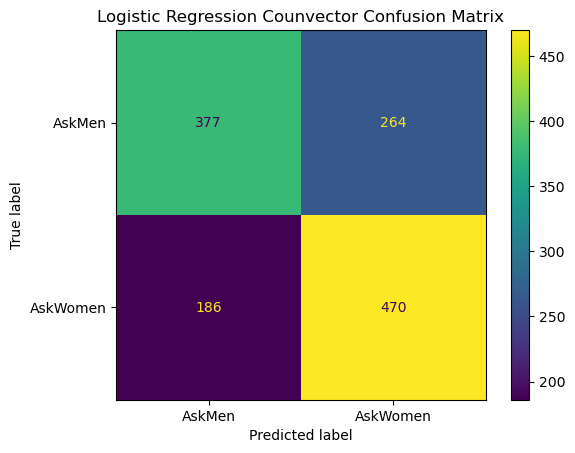

In [137]:
log_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr, X_test, y_test)
log_matrix.ax_.set_title("Logistic Regression Counvector Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/logr_cvec_confusion_matrix')

In [98]:
recall_score(y_test, preds_logr, average='macro')

0.652303470187588

Here we notice a 1% differences in our recall score, which is not much of an improvement. Next we will see if using the TF-IDF Vectorizer will improve performance. In theory it should perform better because its comparing the title (document) to the whole subreddit (corpus).

# Random forest with TF-IDF Vectorizer 

In [99]:
pipe_rf_tf = Pipeline([
    ('tf',TfidfVectorizer())
    ,('rt', RandomForestClassifier())
])

In [101]:
cross_val_score(pipe_rf_tf, X_train, y_train, cv=3).mean()

0.684156378600823

In [102]:
pipe_rf_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('rt', RandomForestClassifier())])

In [103]:
print(f' Training score is {pipe_rf_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_rf_tf.score(X_test, y_test)}')

 Training score is 0.9945987654320988
 Test score is 0.694680030840401


In [106]:
pipe_rf_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'rt__min_samples_leaf': [3, 5, 6],
    'rt__max_depth': [10, 15, 20],
    'rt__bootstrap': [True]
    
}

In [107]:
gs_rf_tf = GridSearchCV(pipe_rf_tf, param_grid=pipe_rf_tf_params, cv=3, n_jobs=-1)

In [ ]:
gs_rf_tf.fit(X_train, y_train)

In [123]:
gs_rf_tf.best_params_

{'rt__bootstrap': True,
 'rt__max_depth': 20,
 'rt__min_samples_leaf': 6,
 'tf__lowercase': True,
 'tf__max_df': 0.8,
 'tf__max_features': 50,
 'tf__min_df': 3,
 'tf__ngram_range': (1, 2),
 'tf__stop_words': None}

Best parmas for a TFID and random forest

|Param|setting|
|-----|-----|
|tf__max_df| .8|
|tf__max_features| 50|
|tf__min_df| 3|
|tf__ngram_range| (1, 2)|
|tf__stop_words| None|
|rt__bootstrap| True|
|rt__max_depth| 20|
|rt__min_samples_leaf| 6|

In [124]:
print(f' Training score is {gs_rf_tf.score(X_train, y_train)}')
print(f' Test score is {gs_rf_tf.score(X_test, y_test)}')

 Training score is 0.7973251028806584
 Test score is 0.6638396299151889


It appears the model did not improve much with the classification rate after incorporating the TFIDF. We will see if it has a recall score to when we used the countvectorizer

In [134]:
preds_rf_tf = gs_rf_tf.predict(X_test)

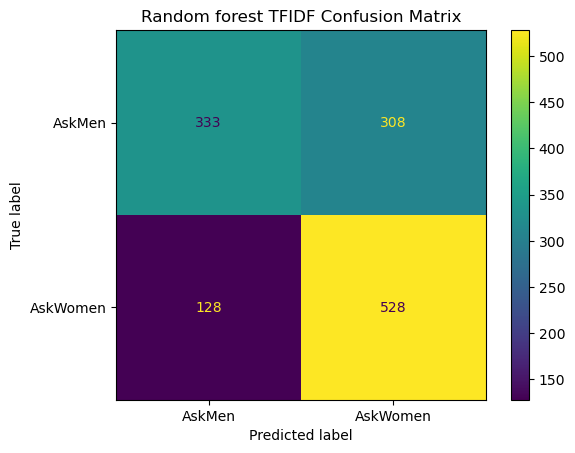

In [138]:
rf_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_rf_tf, X_test, y_test)
rf_tf_matrix.ax_.set_title("Random forest TFIDF Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/Random_forest_tfidf_confusion_matrix')

In [136]:
recall_score(y_test, preds_rf_tf, average='macro')

0.6621894144058446

Her we see a similar recall score (.662~) comapred to our random forest and counvectorizer (.661). Theres not much of an improvment here, but we will see if theres any improvement with our logistical regression.

# Logistic regression with TF-IDF Vectorizer 

In [147]:
pipe_logr_tf = Pipeline([
    ('tf', TfidfVectorizer())
    ,('logr', LogisticRegression())
])

In [148]:
pipe_logr_tf_params = {
    'tf__lowercase': [True],
    'tf__max_features': [30, 50, 75.],
    'tf__min_df': [2, 3, 9],
    'tf__max_df': [0.80, 0.90],
    'tf__ngram_range': [(1, 2), (2,3), (3,4)],
    'tf__stop_words' : ['english', None],
    'logr__C':[.25, .5, .75, 1]
}

In [149]:
cross_val_score(pipe_logr_tf, X_train, y_train, cv=3).mean()

0.6612654320987655

In [151]:
gs_logr_tf = GridSearchCV(pipe_logr_tf, param_grid=pipe_logr_tf_params, cv=3, n_jobs=-1)

In [152]:
pipe_logr_tf.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer()), ('logr', LogisticRegression())])

In [153]:
print(f' Training score is {pipe_logr_tf.score(X_train, y_train)}')
print(f' Test score is {pipe_logr_tf.score(X_test, y_test)}')

 Training score is 0.8359053497942387
 Test score is 0.6861989205859677


In [ ]:
gs_logr_tf.fit(X_train, y_train)

In [157]:
print(f' Training score is {gs_logr_tf.score(X_train, y_train)}')
print(f' Test score is {gs_logr_tf.score(X_test, y_test)}')

 Training score is 0.665380658436214
 Test score is 0.6291441788743254


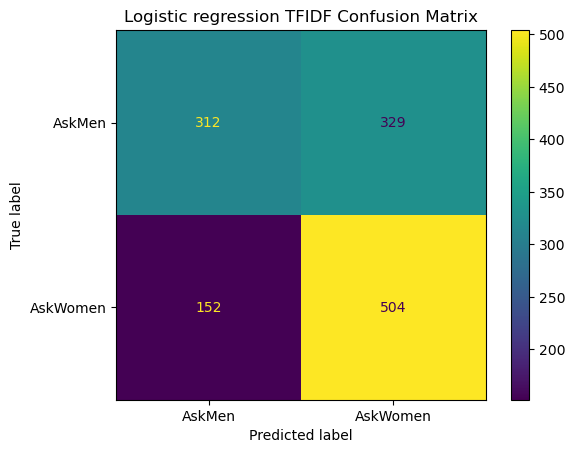

In [158]:
logr_tf_matrix = ConfusionMatrixDisplay.from_estimator(gs_logr_tf, X_test, y_test)
logr_tf_matrix.ax_.set_title("Logistic regression TFIDF Confusion Matrix")
plt.savefig('../Figures/confusion_matrix/Logistic_tfidf_confusion_matrix')

In [160]:
preds_logr_tf = gs_logr_tf.predict(X_test)

In [161]:
recall_score(y_test, preds_logr_tf, average='macro')

0.6275160762528063